In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
import random
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import shap

pd.options.display.max_rows = 999
pd.options.display.max_columns = 500

In [2]:
mainpath = '/Users/nataliaurquiza/Documents/DS/Evaluacion_Kueski/archive/'

## Train y test dataset

In [3]:
# Leyendo archivo movie_df
movie_df = pd.read_csv('movie_df.csv')
movie_df['timestamp'] = pd.to_datetime(movie_df['timestamp'])

# Número de películas rankeadas por año
movie_df.groupby(pd.DatetimeIndex(movie_df['timestamp']).year).userId.count()

timestamp
1995          4
1996    1612609
1997     700982
1998     308070
1999    1198384
2000    1953659
2001    1186125
2002     869719
2003    1035878
2004    1170049
2005    1803158
2006    1171836
2007    1053430
2008    1158777
2009     930036
2010     903691
2011     766366
2012     731389
2013     599327
2014     562888
2015     283886
Name: userId, dtype: int64

In [4]:
# Distribución de la target por género
cols_gen = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']
for gen in cols_gen:
    print(gen)
    print(movie_df.loc[(movie_df[gen] == 1)].y.value_counts(normalize = True))

Action
0    0.539802
1    0.460198
Name: y, dtype: float64
Adventure
0    0.515791
1    0.484209
Name: y, dtype: float64
Animation
1    0.530635
0    0.469365
Name: y, dtype: float64
Children
0    0.548008
1    0.451992
Name: y, dtype: float64
Comedy
0    0.541356
1    0.458644
Name: y, dtype: float64
Crime
1    0.559172
0    0.440828
Name: y, dtype: float64
Documentary
1    0.601319
0    0.398681
Name: y, dtype: float64
Drama
1    0.560114
0    0.439886
Name: y, dtype: float64
Fantasy
0    0.513058
1    0.486942
Name: y, dtype: float64
Film-Noir
1    0.696644
0    0.303356
Name: y, dtype: float64
Horror
0    0.589302
1    0.410698
Name: y, dtype: float64
IMAX
1    0.53422
0    0.46578
Name: y, dtype: float64
Musical
1    0.512425
0    0.487575
Name: y, dtype: float64
Mystery
1    0.556649
0    0.443351
Name: y, dtype: float64
Romance
1    0.503346
0    0.496654
Name: y, dtype: float64
Sci-Fi
0    0.537929
1    0.462071
Name: y, dtype: float64
Thriller
0    0.513725
1    0.486275
Name:

<AxesSubplot:xlabel='timestamp,y'>

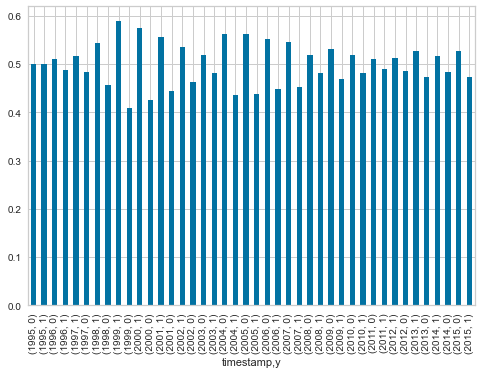

In [5]:
# Distribución de la target por año
movie_df.groupby(pd.DatetimeIndex(movie_df['timestamp']).year).y.value_counts(normalize = True).plot.bar()

### Test dataset

In [6]:
test_data = movie_df.loc[movie_df['timestamp'].dt.year >= 2012][['userId', 'movieId', 
       'timestamp', 'y',
       '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western', 'antig_movie']].reset_index(drop=True)
test_data

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie
0,395,2,2012-06-15 01:30:07,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
1,409,2,2012-05-07 15:50:08,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
2,425,2,2014-12-07 04:16:13,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
3,466,2,2013-09-22 12:20:40,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
4,482,2,2013-08-07 16:37:50,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177485,138301,121017,2015-01-06 15:34:39,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
2177486,138301,121019,2015-01-06 15:36:46,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,51.0
2177487,138301,121021,2015-01-06 15:38:07,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,54.0
2177488,138406,110167,2014-03-30 12:55:27,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0


In [7]:
# Unión con variables set 1 

# género_ventana_tot: Número de películas que el usuario ha rankeado de ese género en cada ventana.
# género_ventana_rat_prom: Promedio del rating que ha dado el usuario a películas de ese género para 
#                          cada ventana de tiempo.
# género_ventana_porc: Número de películas que el usuario ha rankeado de ese género entre el número 
#                      total de películas que el usuario ha rankeado por cada ventana.

cols_gen = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']

ventanas = ['7300d','365d', '90d', '30d', '7d']

for gen in cols_gen:
    
    for ventana in ventanas:    
        filename = 'varset1_' + gen + ventana + '.csv'
        tabla_v1 = pd.read_csv(filename)
        tabla_v1['timestamp'] = pd.to_datetime(tabla_v1['timestamp'])
        test_data = pd.merge(
            test_data,
            tabla_v1,
            on = ['userId', 'timestamp'],
            how = 'left'
            )
        print(ventana)
    print(gen)


7300d
365d
90d
30d
7d
Action
7300d
365d
90d
30d
7d
Adventure
7300d
365d
90d
30d
7d
Animation
7300d
365d
90d
30d
7d
Children
7300d
365d
90d
30d
7d
Comedy
7300d
365d
90d
30d
7d
Crime
7300d
365d
90d
30d
7d
Documentary
7300d
365d
90d
30d
7d
Drama
7300d
365d
90d
30d
7d
Fantasy
7300d
365d
90d
30d
7d
Film-Noir
7300d
365d
90d
30d
7d
Horror
7300d
365d
90d
30d
7d
IMAX
7300d
365d
90d
30d
7d
Musical
7300d
365d
90d
30d
7d
Mystery
7300d
365d
90d
30d
7d
Romance
7300d
365d
90d
30d
7d
Sci-Fi
7300d
365d
90d
30d
7d
Thriller
7300d
365d
90d
30d
7d
War
7300d
365d
90d
30d
7d
Western


In [8]:
test_data

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom
0,395,2,2012-06-15 01:30:07,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,29.0,3.810345,29.0,3.810345,29.0,3.810345,29.0,3.810345,29.0,3.810345,15.0,3.500000,15.0,3.500000,15.0,3.5,15.0,3.500,15.0,3.5,5.0,4.300000,5.0,4.3,5.0,4.3,5.0,4.3,5.0,4.3,11.0,3.818182,11.0,3.818182,11.0,3.818182,11.0,3.818182,11.0,3.818182,19.0,3.000000,19.0,3.000000,19.0,3.000000,19.0,3.0,19.0,3.0,10.0

In [9]:
test_data.describe()

,userId,movieId,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom
count,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177490e+06,2.177090e+06,2.177490e+06,1.007892e+06,2.177490e+06,893299.000000,2.177490e+06,764366.000000,2.177490e+06,636874.000000,2.1774

In [10]:
# Unión con variables set 2

# Antigüedad del usuario
# num_movies_ventana: Número de películas que ha rankeado el usuario para cada ventana de tiempo.
# porc_ventana: Número de películas que ha rankeado el usuario en cada ventana de tiempo entre el 
#               total de películas que ha rankeado.

varset2_antig_user = pd.read_csv('varset2_antig_user.csv')

test_data = pd.merge(
    test_data,
    varset2_antig_user,
    on = ['userId', 'movieId'],
    how = 'left'
)
test_data

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user
0,395,2,2012-06-15 01:30:07,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,29.0,3.810345,29.0,3.810345,29.0,3.810345,29.0,3.810345,29.0,3.810345,15.0,3.500000,15.0,3.500000,15.0,3.5,15.0,3.500,15.0,3.5,5.0,4.300000,5.0,4.3,5.0,4.3,5.0,4.3,5.0,4.3,11.0,3.818182,11.0,3.818182,11.0,3.818182,11.0,3.818182,11.0,3.818182,19.0,3.000000,19.0,3.000000,19.0,3.000000,19.0,3.0,19

In [11]:
ventanas = ['7300d','365d', '90d', '30d', '7d']

for ventana in ventanas:
    filename = 'varset2_' + ventana + '.csv'
    tabla_v2 = pd.read_csv(filename)
    tabla_v2['timestamp'] = pd.to_datetime(tabla_v2['timestamp'])
    test_data = pd.merge(
        test_data,
        tabla_v2,
        on = ['userId', 'timestamp'],
        how = 'left'
        )
    test_data['porc_' + ventana] = test_data['num_movies_' + ventana]/test_data['num_movies_7300d']
    print(ventana)

7300d
365d
90d
30d
7d


In [12]:
test_data.shape

(2177490, 226)

In [14]:
test_data.head()

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user,num_movies_7300d,porc_7300d,num_movies_365d,porc_365d,num_movies_90d,porc_90d,num_movies_30d,porc_30d,num_movies_7d,porc_7d
0,395,2,2012-06-15 01:30:07,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,29.0,3.810345,29.0,3.810345,29.0,3.810345,29.0,3.810345,29.0,3.810345,15.0,3.5,15.0,3.5,15.0,3.5,15.0,3.5,15.0,3.5,5.0,4.3,5.0,4.3,5.0,4.3,5.0,4.3,5.0,4.3,11.0,3.818182,11

In [15]:
# Unión con variables set 3

# Antigüedad de la película
# movie_tot_ventana: Número de usuarios que han visto la película para distintas ventanas de tiempo.
# movie_prom_rat_ventana: Promedio de calificación de la película respecto a todos los usuarios que 
#                         la han visto en distintas ventanas de tiempo.

varset3 = pd.read_csv('varset3.csv')
varset3['timestamp'] = pd.to_datetime(varset3['timestamp'])

test_data = pd.merge(
    test_data,
    varset3,
    on = ['movieId', 'timestamp'],
    how = 'left'
)
test_data

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user,num_movies_7300d,porc_7300d,num_movies_365d,porc_365d,num_movies_90d,porc_90d,num_movies_30d,porc_30d,num_movies_7d,porc_7d,movie_tot_7300d,movie_prom_rat_7300d,movie_tot_365d,movie_prom_rat_365d,movie_tot_90d,movie_prom_rat_90d,movie_tot_30d,movie_prom_rat_30d,movie_tot_7d,movie_prom_rat_7d
0,395,2,2012-06-15 01:30:07,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,29

In [16]:
test_data.head()

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user,num_movies_7300d,porc_7300d,num_movies_365d,porc_365d,num_movies_90d,porc_90d,num_movies_30d,porc_30d,num_movies_7d,porc_7d,movie_tot_7300d,movie_prom_rat_7300d,movie_tot_365d,movie_prom_rat_365d,movie_tot_90d,movie_prom_rat_90d,movie_tot_30d,movie_prom_rat_30d,movie_tot_7d,movie_prom_rat_7d
0,395,2,2012-06-15 01:30:07,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,29

In [17]:
test_data.to_csv('test_data_2012_2015_sinset4.csv', index = False, quoting = 1, encoding = 'utf-8')

In [18]:
# Unión con variables set 4

# cluster_ventana_tot: Número de películas que el usuario ha rankeado de ese cluster en cada ventana de tiempo.
# cluster_ventana_rat_prom: Promedio del rating que ha dado el usuario a películas de ese cluster para cada 
#                           ventana de tiempo.
# cluster_ventana_porc: Número de películas que el usuario ha rankeado de ese cluster entre el número 
#                       total de películas que ha rankeado para distintas ventavas de tiempo.


cols_label = ['label0', 'label1', 'label2', 'label3',
       'label4', 'label5', 'label6', 'label7', 'label8']

ventanas = ['7300d','365d', '90d', '30d', '7d']

for label in cols_label:
    for ventana in ventanas:
        filename = 'varset4_' + label + ventana + '.csv'
        tabla_v4 = pd.read_csv(filename)
        tabla_v4['timestamp'] = pd.to_datetime(tabla_v4['timestamp'])
        test_data = pd.merge(
            test_data,
            tabla_v4,
            on = ['userId', 'timestamp'],
            how = 'left'
            )
        test_data[label + ventana + '_porc'] = test_data[label + ventana + '_tot']/test_data['num_movies_' + ventana]
        print(ventana)
    print(label)

7300d
365d
90d
30d
7d
label0
7300d
365d
90d
30d
7d
label1
7300d
365d
90d
30d
7d
label2
7300d
365d
90d
30d
7d
label3
7300d
365d
90d
30d
7d
label4
7300d
365d
90d
30d
7d
label5
7300d
365d
90d
30d
7d
label6
7300d
365d
90d
30d
7d
label7
7300d
365d


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


90d
30d
7d
label8


In [19]:
test_data.to_csv('test_data_2012_2015_conset4.csv', index = False, quoting = 1, encoding = 'utf-8')

In [20]:
test_data

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user,num_movies_7300d,porc_7300d,num_movies_365d,porc_365d,num_movies_90d,porc_90d,num_movies_30d,porc_30d,num_movies_7d,porc_7d,movie_tot_7300d,movie_prom_rat_7300d,movie_tot_365d,movie_prom_rat_365d,movie_tot_90d,movie_prom_rat_90d,movie_tot_30d,movie_prom_rat_30d,movie_tot_7d,movie_prom_rat_7d,label07300d_tot,label07300d_rat_prom,label07300d_porc,label0365d_tot,label0365d_rat_prom,label0365d_porc,label090d_to

In [21]:
# género_ventana_porc: Número de películas que el usuario ha rankeado de ese género entre el número 
#                      total de películas que el usuario ha rankeado por cada ventana.

cols_gen = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']

ventanas = ['7300d','365d', '90d', '30d', '7d']

for gen in cols_gen:
    
    for ventana in ventanas:    
        test_data[gen + ventana + '_porc'] = test_data[gen + ventana + '_tot']/test_data['num_movies_' + ventana]
        print(ventana)
    print(gen)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


7300d
365d
90d
30d
7d
Action
7300d
365d
90d
30d
7d
Adventure
7300d
365d
90d
30d
7d
Animation
7300d
365d
90d
30d
7d
Children
7300d
365d
90d
30d
7d
Comedy
7300d
365d
90d
30d
7d
Crime
7300d
365d
90d
30d
7d
Documentary
7300d
365d
90d
30d
7d
Drama
7300d
365d
90d
30d
7d
Fantasy
7300d
365d
90d
30d
7d
Film-Noir
7300d
365d
90d
30d
7d
Horror
7300d
365d
90d
30d
7d
IMAX
7300d
365d
90d
30d
7d
Musical
7300d
365d
90d
30d
7d
Mystery
7300d
365d
90d
30d
7d
Romance
7300d
365d
90d
30d
7d
Sci-Fi
7300d
365d
90d
30d
7d
Thriller
7300d
365d
90d
30d
7d
War
7300d
365d
90d
30d
7d
Western


In [23]:
test_data.to_csv('test_data_2012_2015_final.csv', index = False, quoting = 1, encoding = 'utf-8')

In [22]:
test_data.shape

(2177490, 466)

In [ ]:
test_data.describe()

In [39]:
# Distribución de la target por género en el test dataset
cols_gen = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']
for gen in cols_gen:
    print(gen)
    print(test_data.loc[(test_data[gen] == 1)].y.value_counts(normalize = True))

Action
0    0.505683
1    0.494317
Name: y, dtype: float64
Adventure
1    0.508578
0    0.491422
Name: y, dtype: float64
Animation
1    0.535863
0    0.464137
Name: y, dtype: float64
Children
0    0.531229
1    0.468771
Name: y, dtype: float64
Comedy
0    0.539751
1    0.460249
Name: y, dtype: float64
Crime
1    0.578477
0    0.421523
Name: y, dtype: float64
Documentary
1    0.554028
0    0.445972
Name: y, dtype: float64
Drama
1    0.5638
0    0.4362
Name: y, dtype: float64
Fantasy
1    0.508121
0    0.491879
Name: y, dtype: float64
Film-Noir
1    0.623655
0    0.376345
Name: y, dtype: float64
Horror
0    0.57898
1    0.42102
Name: y, dtype: float64
IMAX
1    0.531277
0    0.468723
Name: y, dtype: float64
Musical
1    0.501808
0    0.498192
Name: y, dtype: float64
Mystery
1    0.571395
0    0.428605
Name: y, dtype: float64
Romance
0    0.500688
1    0.499312
Name: y, dtype: float64
Sci-Fi
1    0.502242
0    0.497758
Name: y, dtype: float64
Thriller
1    0.510049
0    0.489951
Name: y, 

<AxesSubplot:xlabel='timestamp,y'>

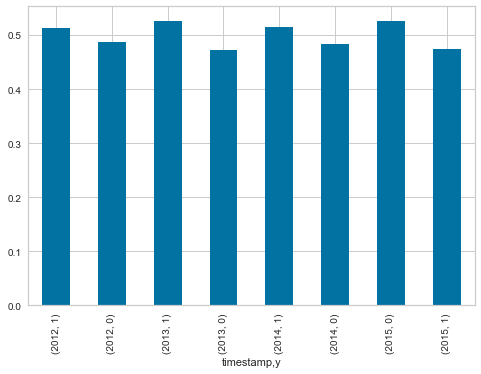

In [42]:
# Distribución de la target por año en el test dataset
test_data.groupby(pd.DatetimeIndex(test_data['timestamp']).year).y.value_counts(normalize = True).plot.bar()

### Train dataset

In [3]:
# Leyendo archivo movie_df
movie_df = pd.read_csv('movie_df.csv')
movie_df['timestamp'] = pd.to_datetime(movie_df['timestamp'])

In [4]:
train_data = movie_df.loc[movie_df['timestamp'].dt.year < 2012].sample(n=4000000,
                                                           replace=False, 
                                                          random_state=42)[['userId', 'movieId', 
       'timestamp', 'y',
       '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western', 'antig_movie']].reset_index(drop=True)
del(movie_df)
train_data

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie
0,118260,353,2006-02-24 10:12:42,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0
1,120572,514,2006-05-19 21:50:48,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
2,80323,2571,2007-09-08 02:13:14,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,8.0
3,76171,1379,1997-10-08 16:18:13,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0
4,74966,3033,2010-05-15 11:57:50,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,126168,3451,2000-08-02 02:54:48,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
3999996,4308,8783,2005-06-02 17:34:47,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3999997,47629,1287,2006-03-17 22:59:47,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0
3999998,112203,3114,2007-04-08 04:22:31,1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0


In [5]:
# Unión con variables set 1 

# género_ventana_tot: Número de películas que el usuario ha rankeado de ese género en cada ventana.
# género_ventana_rat_prom: Promedio del rating que ha dado el usuario a películas de ese género para 
#                          cada ventana de tiempo.
# género_ventana_porc: Número de películas que el usuario ha rankeado de ese género entre el número 
#                      total de películas que el usuario ha rankeado por cada ventana.

cols_gen = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']

ventanas = ['7300d','365d', '90d', '30d', '7d']

for gen in cols_gen:
    
    for ventana in ventanas:    
        filename = 'varset1_' + gen + ventana + '.csv'
        tabla_v1 = pd.read_csv(filename)
        tabla_v1['timestamp'] = pd.to_datetime(tabla_v1['timestamp'])
        train_data = pd.merge(
            train_data,
            tabla_v1,
            on = ['userId', 'timestamp'],
            how = 'left'
            )
        print(ventana)
    print(gen)


7300d
365d
90d
30d
7d
Action
7300d
365d
90d
30d
7d
Adventure
7300d
365d
90d
30d
7d
Animation
7300d
365d
90d
30d
7d
Children
7300d
365d
90d
30d
7d
Comedy
7300d
365d
90d
30d
7d
Crime
7300d
365d
90d
30d
7d
Documentary
7300d
365d
90d
30d
7d
Drama
7300d
365d
90d
30d
7d
Fantasy
7300d
365d
90d
30d
7d
Film-Noir
7300d
365d
90d
30d
7d
Horror
7300d
365d
90d
30d
7d
IMAX
7300d
365d
90d
30d
7d
Musical
7300d
365d
90d
30d
7d
Mystery
7300d
365d
90d
30d
7d
Romance
7300d
365d
90d
30d
7d
Sci-Fi
7300d
365d
90d
30d
7d
Thriller
7300d
365d
90d
30d
7d
War
7300d
365d
90d
30d


KeyboardInterrupt: 

In [6]:
train_data.head()

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom
0,118260,353,2006-02-24 10:12:42,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,Na

In [7]:
train_data.shape

(4000000, 213)

In [11]:
for col in train_data.columns:
    print(col)

userId
movieId
timestamp
y
(no genres listed)
Action
Adventure
Animation
Children
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
IMAX
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western
antig_movie
Action7300d_tot
Action7300d_rat_prom
Action365d_tot
Action365d_rat_prom
Action90d_tot
Action90d_rat_prom
Action30d_tot
Action30d_rat_prom
Action7d_tot
Action7d_rat_prom
Adventure7300d_tot
Adventure7300d_rat_prom
Adventure365d_tot
Adventure365d_rat_prom
Adventure90d_tot
Adventure90d_rat_prom
Adventure30d_tot
Adventure30d_rat_prom
Adventure7d_tot
Adventure7d_rat_prom
Animation7300d_tot
Animation7300d_rat_prom
Animation365d_tot
Animation365d_rat_prom
Animation90d_tot
Animation90d_rat_prom
Animation30d_tot
Animation30d_rat_prom
Animation7d_tot
Animation7d_rat_prom
Children7300d_tot
Children7300d_rat_prom
Children365d_tot
Children365d_rat_prom
Children90d_tot
Children90d_rat_prom
Children30d_tot
Children30d_rat_prom
Children7d_tot
Children7d_rat_prom
Comedy7300d_tot
Comedy7300d_rat_prom


In [12]:
filename = 'varset1_Western7d.csv'
tabla_v1 = pd.read_csv(filename)
tabla_v1['timestamp'] = pd.to_datetime(tabla_v1['timestamp'])
train_data = pd.merge(
    train_data,
    tabla_v1[['userId', 'timestamp', 'Western7d_tot', 'Western7d_rat_prom']],
    on = ['userId', 'timestamp'],
    how = 'left'
    )

In [13]:
train_data.head()

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom
0,118260,353,2006-02-24 10:12:42,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,N

In [14]:
train_data.shape

(4000000, 215)

In [15]:
del(tabla_v1)

In [16]:
# Unión con variables set 2

# Antigüedad del usuario
# num_movies_ventana: Número de películas que ha rankeado el usuario para cada ventana de tiempo.
# porc_ventana: Número de películas que ha rankeado el usuario en cada ventana de tiempo entre el 
#               total de películas que ha rankeado.

varset2_antig_user = pd.read_csv('varset2_antig_user.csv')

train_data = pd.merge(
    train_data,
    varset2_antig_user,
    on = ['userId', 'movieId'],
    how = 'left'
)
del(varset2_antig_user)
train_data

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user
0,118260,353,2006-02-24 10:12:42,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.

In [17]:
ventanas = ['7300d','365d', '90d', '30d', '7d']

for ventana in ventanas:
    filename = 'varset2_' + ventana + '.csv'
    tabla_v2 = pd.read_csv(filename)
    tabla_v2['timestamp'] = pd.to_datetime(tabla_v2['timestamp'])
    train_data = pd.merge(
        train_data,
        tabla_v2,
        on = ['userId', 'timestamp'],
        how = 'left'
        )
    train_data['porc_' + ventana] = train_data['num_movies_' + ventana]/train_data['num_movies_7300d']
    print(ventana)
del(tabla_v2)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


7300d
365d
90d
30d
7d


In [18]:
train_data.head()

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user,num_movies_7300d,porc_7300d,num_movies_365d,porc_365d,num_movies_90d,porc_90d,num_movies_30d,porc_30d,num_movies_7d,porc_7d
0,118260,353,2006-02-24 10:12:42,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,Na

In [20]:
train_data.shape

(4000000, 226)

In [22]:
# Unión con variables set 3

# Antigüedad de la película
# movie_tot_ventana: Número de usuarios que han visto la película para distintas ventanas de tiempo.
# movie_prom_rat_ventana: Promedio de calificación de la película respecto a todos los usuarios que 
#                         la han visto en distintas ventanas de tiempo.

varset3 = pd.read_csv('varset3.csv')
varset3['timestamp'] = pd.to_datetime(varset3['timestamp'])

train_data = pd.merge(
    train_data,
    varset3,
    on = ['movieId', 'timestamp'],
    how = 'left'
)
del(varset3)
train_data.head()

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user,num_movies_7300d,porc_7300d,num_movies_365d,porc_365d,num_movies_90d,porc_90d,num_movies_30d,porc_30d,num_movies_7d,porc_7d,movie_tot_7300d,movie_prom_rat_7300d,movie_tot_365d,movie_prom_rat_365d,movie_tot_90d,movie_prom_rat_90d,movie_tot_30d,movie_prom_rat_30d,movie_tot_7d,movie_prom_rat_7d
0,118260,353,2006-02-24 10:12:42,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12

In [23]:
train_data.shape

(4000000, 236)

In [24]:
train_data.to_csv('train_data_1995_2011_sinset4.csv', index = False, quoting = 1, encoding = 'utf-8')

In [3]:
train_data = pd.read_csv('train_data_1995_2011_sinset4.csv')
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

In [4]:
# Unión con variables set 4

# cluster_ventana_tot: Número de películas que el usuario ha rankeado de ese cluster en cada ventana de tiempo.
# cluster_ventana_rat_prom: Promedio del rating que ha dado el usuario a películas de ese cluster para cada 
#                           ventana de tiempo.
# cluster_ventana_porc: Número de películas que el usuario ha rankeado de ese cluster entre el número 
#                       total de películas que ha rankeado para distintas ventavas de tiempo.

cols_label = ['label0', 'label1', 'label2', 'label3',
       'label4', 'label5', 'label6', 'label7', 'label8']

ventanas = ['7300d','365d', '90d', '30d', '7d']

for label in cols_label:
    for ventana in ventanas:
        filename = 'varset4_' + label + ventana + '.csv'
        tabla_v4 = pd.read_csv(filename)
        tabla_v4['timestamp'] = pd.to_datetime(tabla_v4['timestamp'])
        train_data = pd.merge(
            train_data,
            tabla_v4,
            on = ['userId', 'timestamp'],
            how = 'left'
            )
        train_data[label + ventana + '_porc'] = train_data[label + ventana + '_tot']/train_data['num_movies_' + ventana]
        print(ventana)
    print(label)

7300d
365d
90d
30d
7d
label0
7300d
365d
90d
30d
7d
label1
7300d
365d
90d
30d
7d
label2
7300d
365d
90d
30d
7d
label3
7300d
365d
90d
30d
7d
label4
7300d
365d
90d
30d
7d
label5
7300d
365d
90d
30d
7d
label6
7300d
365d
90d
30d
7d
label7
7300d
365d
90d
30d
7d
label8


In [5]:
del(tabla_v4)

In [6]:
train_data.head()

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user,num_movies_7300d,porc_7300d,num_movies_365d,porc_365d,num_movies_90d,porc_90d,num_movies_30d,porc_30d,num_movies_7d,porc_7d,movie_tot_7300d,movie_prom_rat_7300d,movie_tot_365d,movie_prom_rat_365d,movie_tot_90d,movie_prom_rat_90d,movie_tot_30d,movie_prom_rat_30d,movie_tot_7d,movie_prom_rat_7d,label07300d_tot,label07300d_rat_prom,label07300d_porc,label0365d_tot,label0365d_rat_prom,label0365d_porc,label090d_to

In [7]:
train_data.shape

(4000000, 371)

In [8]:
train_data.to_csv('train_data_1995_2011_conset4.csv', index = False, quoting = 1, encoding = 'utf-8')

In [9]:
# género_ventana_porc: Número de películas que el usuario ha rankeado de ese género entre el número 
#                      total de películas que el usuario ha rankeado por cada ventana.

cols_gen = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']

ventanas = ['7300d','365d', '90d', '30d', '7d']

for gen in cols_gen:
    
    for ventana in ventanas:    
        train_data[gen + ventana + '_porc'] = train_data[gen + ventana + '_tot']/train_data['num_movies_' + ventana]
        print(ventana)
    print(gen)

7300d
365d
90d
30d


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


7d
Action
7300d
365d
90d
30d
7d
Adventure
7300d
365d
90d
30d
7d
Animation
7300d
365d
90d
30d
7d
Children
7300d
365d
90d
30d
7d
Comedy
7300d
365d
90d
30d
7d
Crime
7300d
365d
90d
30d
7d
Documentary
7300d
365d
90d
30d
7d
Drama
7300d
365d
90d
30d
7d
Fantasy
7300d
365d
90d
30d
7d
Film-Noir
7300d
365d
90d
30d
7d
Horror
7300d
365d
90d
30d
7d
IMAX
7300d
365d
90d
30d
7d
Musical
7300d
365d
90d
30d
7d
Mystery
7300d
365d
90d
30d
7d
Romance
7300d
365d
90d
30d
7d
Sci-Fi
7300d
365d
90d
30d
7d
Thriller
7300d
365d
90d
30d
7d
War
7300d
365d
90d
30d
7d
Western


In [10]:
train_data.head()

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user,num_movies_7300d,porc_7300d,num_movies_365d,porc_365d,num_movies_90d,porc_90d,num_movies_30d,porc_30d,num_movies_7d,porc_7d,movie_tot_7300d,movie_prom_rat_7300d,movie_tot_365d,movie_prom_rat_365d,movie_tot_90d,movie_prom_rat_90d,movie_tot_30d,movie_prom_rat_30d,movie_tot_7d,movie_prom_rat_7d,label07300d_tot,label07300d_rat_prom,label07300d_porc,label0365d_tot,label0365d_rat_prom,label0365d_porc,label090d_to

In [11]:
train_data.shape

(4000000, 466)

In [12]:
train_data.to_csv('train_data_1995_2011_final.csv', index = False, quoting = 1, encoding = 'utf-8')

In [21]:
# Distribución de la target por género en el train dataset
cols_gen = ['Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']
for gen in cols_gen:
    print(gen)
    print(train_data.loc[(train_data[gen] == 1)].y.value_counts(normalize = True))

Action
0    0.544388
1    0.455612
Name: y, dtype: float64
Adventure
0    0.519679
1    0.480321
Name: y, dtype: float64
Animation
1    0.530156
0    0.469844
Name: y, dtype: float64
Children
0    0.54972
1    0.45028
Name: y, dtype: float64
Comedy
0    0.540889
1    0.459111
Name: y, dtype: float64
Crime
1    0.556471
0    0.443529
Name: y, dtype: float64
Documentary
1    0.610375
0    0.389625
Name: y, dtype: float64
Drama
1    0.559721
0    0.440279
Name: y, dtype: float64
Fantasy
0    0.515429
1    0.484571
Name: y, dtype: float64
Film-Noir
1    0.704504
0    0.295496
Name: y, dtype: float64
Horror
0    0.5906
1    0.4094
Name: y, dtype: float64
IMAX
1    0.535909
0    0.464091
Name: y, dtype: float64
Musical
1    0.513397
0    0.486603
Name: y, dtype: float64
Mystery
1    0.555066
0    0.444934
Name: y, dtype: float64
Romance
1    0.504271
0    0.495729
Name: y, dtype: float64
Sci-Fi
0    0.543631
1    0.456369
Name: y, dtype: float64
Thriller
0    0.516044
1    0.483956
Name: y, 

<AxesSubplot:xlabel='timestamp,y'>

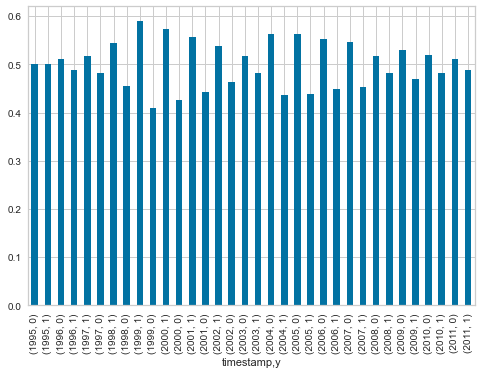

In [22]:
# Distribución de la target por año en el test dataset
train_data.groupby(pd.DatetimeIndex(train_data['timestamp']).year).y.value_counts(normalize = True).plot.bar()

In [31]:
# Actualizar el train_data
#train_data.columns:

userId
movieId
timestamp
y
(no genres listed)
Action
Adventure
Animation
Children
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
IMAX
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western
antig_movie
user_tot
Action_tot
Action_rat_prom
Action_porc
Adventure_tot
Adventure_rat_prom
Adventure_porc
Animation_tot
Animation_rat_prom
Animation_porc
Children_tot
Children_rat_prom
Children_porc
Comedy_tot
Comedy_rat_prom
Comedy_porc
Crime_tot
Crime_rat_prom
Crime_porc
Documentary_tot
Documentary_rat_prom
Documentary_porc
Drama_tot
Drama_rat_prom
Drama_porc
Fantasy_tot
Fantasy_rat_prom
Fantasy_porc
Film-Noir_tot
Film-Noir_rat_prom
Film-Noir_porc
Horror_tot
Horror_rat_prom
Horror_porc
IMAX_tot
IMAX_rat_prom
IMAX_porc
Musical_tot
Musical_rat_prom
Musical_porc
Mystery_tot
Mystery_rat_prom
Mystery_porc
Romance_tot
Romance_rat_prom
Romance_porc
Sci-Fi_tot
Sci-Fi_rat_prom
Sci-Fi_porc
Thriller_tot
Thriller_rat_prom
Thriller_porc
War_tot
War_rat_prom
War_porc
Western_tot
Western_rat_prom
Western_

In [32]:
#for col in train_data.columns:
#    if 'rat' in col:
#        train_data[col] = np.where(train_data[col] >= 4,
#                                  1,
#                                  0)
#    print(col)

userId
movieId
timestamp
y
(no genres listed)
Action
Adventure
Animation
Children
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
IMAX
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western
antig_movie
user_tot
Action_tot
Action_rat_prom
Action_porc
Adventure_tot
Adventure_rat_prom
Adventure_porc
Animation_tot
Animation_rat_prom
Animation_porc
Children_tot
Children_rat_prom
Children_porc
Comedy_tot
Comedy_rat_prom
Comedy_porc
Crime_tot
Crime_rat_prom
Crime_porc
Documentary_tot
Documentary_rat_prom
Documentary_porc
Drama_tot
Drama_rat_prom
Drama_porc
Fantasy_tot
Fantasy_rat_prom
Fantasy_porc
Film-Noir_tot
Film-Noir_rat_prom
Film-Noir_porc
Horror_tot
Horror_rat_prom
Horror_porc
IMAX_tot
IMAX_rat_prom
IMAX_porc
Musical_tot
Musical_rat_prom
Musical_porc
Mystery_tot
Mystery_rat_prom
Mystery_porc
Romance_tot
Romance_rat_prom
Romance_porc
Sci-Fi_tot
Sci-Fi_rat_prom
Sci-Fi_porc
Thriller_tot
Thriller_rat_prom
Thriller_porc
War_tot
War_rat_prom
War_porc
Western_tot
Western_rat_prom
Western_

# Modelado con XGBoost

### Selección de variables

In [3]:
chunksize = 1000
train_data = pd.concat([chunk.sample(frac=0.5, replace=False, random_state=42) for chunk in pd.read_csv('train_data_1995_2011_final.csv', chunksize=chunksize)],
                      axis = 0)

In [4]:
train_data.shape

(2000000, 466)

In [5]:
train_data.head()

,userId,movieId,timestamp,y,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,antig_movie,Action7300d_tot,Action7300d_rat_prom,Action365d_tot,Action365d_rat_prom,Action90d_tot,Action90d_rat_prom,Action30d_tot,Action30d_rat_prom,Action7d_tot,Action7d_rat_prom,Adventure7300d_tot,Adventure7300d_rat_prom,Adventure365d_tot,Adventure365d_rat_prom,Adventure90d_tot,Adventure90d_rat_prom,Adventure30d_tot,Adventure30d_rat_prom,Adventure7d_tot,Adventure7d_rat_prom,Animation7300d_tot,Animation7300d_rat_prom,Animation365d_tot,Animation365d_rat_prom,Animation90d_tot,Animation90d_rat_prom,Animation30d_tot,Animation30d_rat_prom,Animation7d_tot,Animation7d_rat_prom,Children7300d_tot,Children7300d_rat_prom,Children365d_tot,Children365d_rat_prom,Children90d_tot,Children90d_rat_prom,Children30d_tot,Children30d_rat_prom,Children7d_tot,Children7d_rat_prom,Comedy7300d_tot,Comedy7300d_rat_prom,Comedy365d_tot,Comedy365d_rat_prom,Comedy90d_tot,Comedy90d_rat_prom,Comedy30d_tot,Comedy30d_rat_prom,Comedy7d_tot,Comedy7d_rat_prom,Crime7300d_tot,Crime7300d_rat_prom,Crime365d_tot,Crime365d_rat_prom,Crime90d_tot,Crime90d_rat_prom,Crime30d_tot,Crime30d_rat_prom,Crime7d_tot,Crime7d_rat_prom,Documentary7300d_tot,Documentary7300d_rat_prom,Documentary365d_tot,Documentary365d_rat_prom,Documentary90d_tot,Documentary90d_rat_prom,Documentary30d_tot,Documentary30d_rat_prom,Documentary7d_tot,Documentary7d_rat_prom,Drama7300d_tot,Drama7300d_rat_prom,Drama365d_tot,Drama365d_rat_prom,Drama90d_tot,Drama90d_rat_prom,Drama30d_tot,Drama30d_rat_prom,Drama7d_tot,Drama7d_rat_prom,Fantasy7300d_tot,Fantasy7300d_rat_prom,Fantasy365d_tot,Fantasy365d_rat_prom,Fantasy90d_tot,Fantasy90d_rat_prom,Fantasy30d_tot,Fantasy30d_rat_prom,Fantasy7d_tot,Fantasy7d_rat_prom,Film-Noir7300d_tot,Film-Noir7300d_rat_prom,Film-Noir365d_tot,Film-Noir365d_rat_prom,Film-Noir90d_tot,Film-Noir90d_rat_prom,Film-Noir30d_tot,Film-Noir30d_rat_prom,Film-Noir7d_tot,Film-Noir7d_rat_prom,Horror7300d_tot,Horror7300d_rat_prom,Horror365d_tot,Horror365d_rat_prom,Horror90d_tot,Horror90d_rat_prom,Horror30d_tot,Horror30d_rat_prom,Horror7d_tot,Horror7d_rat_prom,IMAX7300d_tot,IMAX7300d_rat_prom,IMAX365d_tot,IMAX365d_rat_prom,IMAX90d_tot,IMAX90d_rat_prom,IMAX30d_tot,IMAX30d_rat_prom,IMAX7d_tot,IMAX7d_rat_prom,Musical7300d_tot,Musical7300d_rat_prom,Musical365d_tot,Musical365d_rat_prom,Musical90d_tot,Musical90d_rat_prom,Musical30d_tot,Musical30d_rat_prom,Musical7d_tot,Musical7d_rat_prom,Mystery7300d_tot,Mystery7300d_rat_prom,Mystery365d_tot,Mystery365d_rat_prom,Mystery90d_tot,Mystery90d_rat_prom,Mystery30d_tot,Mystery30d_rat_prom,Mystery7d_tot,Mystery7d_rat_prom,Romance7300d_tot,Romance7300d_rat_prom,Romance365d_tot,Romance365d_rat_prom,Romance90d_tot,Romance90d_rat_prom,Romance30d_tot,Romance30d_rat_prom,Romance7d_tot,Romance7d_rat_prom,Sci-Fi7300d_tot,Sci-Fi7300d_rat_prom,Sci-Fi365d_tot,Sci-Fi365d_rat_prom,Sci-Fi90d_tot,Sci-Fi90d_rat_prom,Sci-Fi30d_tot,Sci-Fi30d_rat_prom,Sci-Fi7d_tot,Sci-Fi7d_rat_prom,Thriller7300d_tot,Thriller7300d_rat_prom,Thriller365d_tot,Thriller365d_rat_prom,Thriller90d_tot,Thriller90d_rat_prom,Thriller30d_tot,Thriller30d_rat_prom,Thriller7d_tot,Thriller7d_rat_prom,War7300d_tot,War7300d_rat_prom,War365d_tot,War365d_rat_prom,War90d_tot,War90d_rat_prom,War30d_tot,War30d_rat_prom,War7d_tot,War7d_rat_prom,Western7300d_tot,Western7300d_rat_prom,Western365d_tot,Western365d_rat_prom,Western90d_tot,Western90d_rat_prom,Western30d_tot,Western30d_rat_prom,Western7d_tot,Western7d_rat_prom,antig_user,num_movies_7300d,porc_7300d,num_movies_365d,porc_365d,num_movies_90d,porc_90d,num_movies_30d,porc_30d,num_movies_7d,porc_7d,movie_tot_7300d,movie_prom_rat_7300d,movie_tot_365d,movie_prom_rat_365d,movie_tot_90d,movie_prom_rat_90d,movie_tot_30d,movie_prom_rat_30d,movie_tot_7d,movie_prom_rat_7d,label07300d_tot,label07300d_rat_prom,label07300d_porc,label0365d_tot,label0365d_rat_prom,label0365d_porc,label090d_to

<AxesSubplot:xlabel='timestamp,y'>

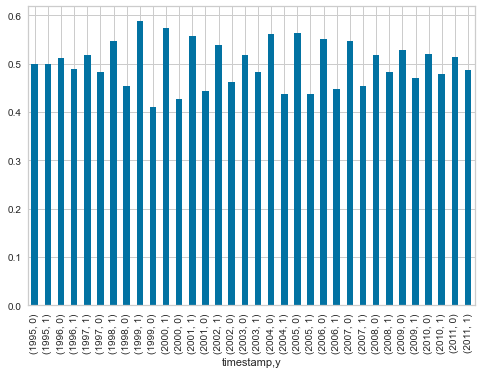

In [6]:
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

# Distribución de la target por año en el test dataset
train_data.groupby(pd.DatetimeIndex(train_data['timestamp']).year).y.value_counts(normalize = True).plot.bar()

In [7]:
# Conjunto de entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(['userId', 'movieId', 'timestamp', 'y'], 
                                                                      axis=1),
                                                    train_data['y'],
                                                    test_size = 0.3,
                                                    random_state = 42)
print('El conjunto de entrenamiento tiene:', X_train.shape[0], 'observaciones')
print('y', sum(y_train), 'con y=1')

print('El conjunto de validación tiene:', X_valid.shape[0], 'observaciones')
print('y', sum(y_valid), 'con y=1')

El conjunto de entrenamiento tiene: 1400000 observaciones
y 697822 con y=1
El conjunto de validación tiene: 600000 observaciones
y 298717 con y=1


In [8]:
del(train_data)

In [9]:
# Modelo para seleccionar variables
dtrain = xgb.DMatrix(X_train, label = y_train)
dvalid = xgb.DMatrix(X_valid, label = y_valid)

evallist = [(dvalid, 'eval'), (dtrain, 'train')]

param = {'max_depth':5, 
         'eta':0.3,
         'objective':'binary:logistic',
         'nthread':-1,
         'eval_metric':'auc'}

bst = xgb.train(param, dtrain, 30, evallist)

[0]	eval-auc:0.74274	train-auc:0.74298
[1]	eval-auc:0.74669	train-auc:0.74693
[2]	eval-auc:0.74849	train-auc:0.74890
[3]	eval-auc:0.74948	train-auc:0.74995
[4]	eval-auc:0.75017	train-auc:0.75072
[5]	eval-auc:0.75077	train-auc:0.75139
[6]	eval-auc:0.75129	train-auc:0.75189
[7]	eval-auc:0.75165	train-auc:0.75244
[8]	eval-auc:0.75206	train-auc:0.75282
[9]	eval-auc:0.75236	train-auc:0.75310
[10]	eval-auc:0.75273	train-auc:0.75338
[11]	eval-auc:0.75303	train-auc:0.75365
[12]	eval-auc:0.75322	train-auc:0.75384
[13]	eval-auc:0.75347	train-auc:0.75403
[14]	eval-auc:0.75366	train-auc:0.75420
[15]	eval-auc:0.75394	train-auc:0.75442
[16]	eval-auc:0.75408	train-auc:0.75455
[17]	eval-auc:0.75429	train-auc:0.75482
[18]	eval-auc:0.75440	train-auc:0.75495
[19]	eval-auc:0.75460	train-auc:0.75516
[20]	eval-auc:0.75473	train-auc:0.75536
[21]	eval-auc:0.75478	train-auc:0.75547
[22]	eval-auc:0.75499	train-auc:0.75574
[23]	eval-auc:0.75511	train-auc:0.75594
[24]	eval-auc:0.75519	train-auc:0.75603
[25]	eval-

In [18]:
# Gain promedio de cada variable
f_importance = pd.DataFrame(list(bst.get_score(importance_type='gain').items()), columns = ['feature', 'gain'])
f_importance.sort_values(by='gain', ascending = False).reset_index(drop=True).head(150).feature.values

array(['movie_prom_rat_365d', 'Drama7300d_rat_prom',
       'Action7300d_rat_prom', 'Comedy7300d_rat_prom',
       'movie_prom_rat_90d', 'Romance365d_rat_prom',
       'Romance7300d_rat_prom', 'Adventure7300d_rat_prom',
       'label27300d_rat_prom', 'label07300d_rat_prom',
       'Drama365d_rat_prom', 'label47300d_rat_prom',
       'label87300d_rat_prom', 'movie_prom_rat_30d',
       'label3365d_rat_prom', 'Drama90d_rat_prom', 'label290d_rat_prom',
       'label2365d_rat_prom', 'IMAX365d_rat_prom', 'label0365d_rat_prom',
       'IMAX7300d_rat_prom', 'label67300d_rat_prom',
       'label37300d_rat_prom', 'Documentary365d_rat_prom',
       'Comedy365d_rat_prom', 'label390d_rat_prom',
       'Adventure365d_rat_prom', 'Comedy90d_rat_prom',
       'label6365d_rat_prom', 'Documentary7d_rat_prom',
       'movie_prom_rat_7300d', 'label030d_rat_prom',
       'label1365d_rat_prom', 'label8365d_rat_prom',
       'Film-Noir7300d_rat_prom', 'label330d_rat_prom',
       'Documentary90d_rat_prom', '

In [12]:
# 150 variables más importantes
f_importance = pd.DataFrame(list(bst.get_score(importance_type='gain').items()), columns = ['feature', 'gain'])
f_importance.sort_values(by='gain', ascending = False).reset_index(drop=True).head(150)

,feature,gain
0,movie_prom_rat_365d,6183.990723
1,Drama7300d_rat_prom,1999.101929
2,Action7300d_rat_prom,1518.774658
3,Comedy7300d_rat_prom,1509.942139
4,movie_prom_rat_90d,1051.574341
5,Romance365d_rat_prom,773.626953
6,Romance7300d_rat_prom,759.974609
7,Adventure7300d_rat_prom,645.511108
8,label27300d_rat_prom,631.810486
9,label07300d_rat_prom,610.180725


<AxesSubplot:ylabel='feature'>

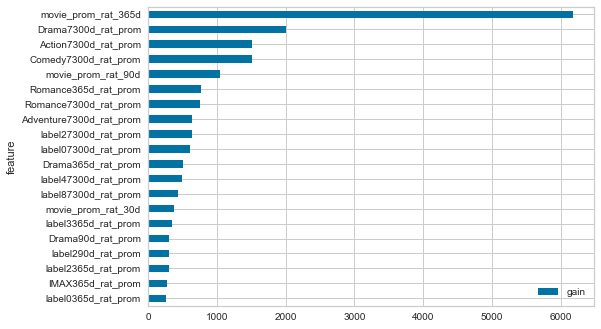

In [11]:
# Feature importance
f_importance = pd.DataFrame(list(bst.get_score(importance_type='gain').items()), columns = ['feature', 'gain'])
f_importance.sort_values(by='gain', ascending = True).reset_index(drop=True).tail(20).set_index('feature').plot.barh()

In [17]:
# Guardar el modelo
bst.save_model('model_2millones.json')

### Ajuste de modelo con las 150 variables seleccionadas

In [3]:
# Variables objetivo: Se seleccionan las 150 variables con mayor gain
features_objetivo = ['movie_prom_rat_365d', 'Drama7300d_rat_prom',
       'Action7300d_rat_prom', 'Comedy7300d_rat_prom',
       'movie_prom_rat_90d', 'Romance365d_rat_prom',
       'Romance7300d_rat_prom', 'Adventure7300d_rat_prom',
       'label27300d_rat_prom', 'label07300d_rat_prom',
       'Drama365d_rat_prom', 'label47300d_rat_prom',
       'label87300d_rat_prom', 'movie_prom_rat_30d',
       'label3365d_rat_prom', 'Drama90d_rat_prom', 'label290d_rat_prom',
       'label2365d_rat_prom', 'IMAX365d_rat_prom', 'label0365d_rat_prom',
       'IMAX7300d_rat_prom', 'label67300d_rat_prom',
       'label37300d_rat_prom', 'Documentary365d_rat_prom',
       'Comedy365d_rat_prom', 'label390d_rat_prom',
       'Adventure365d_rat_prom', 'Comedy90d_rat_prom',
       'label6365d_rat_prom', 'Documentary7d_rat_prom',
       'movie_prom_rat_7300d', 'label030d_rat_prom',
       'label1365d_rat_prom', 'label8365d_rat_prom',
       'Film-Noir7300d_rat_prom', 'label330d_rat_prom',
       'Documentary90d_rat_prom', 'movie_prom_rat_7d',
       'label17300d_rat_prom', 'Adventure', 'label27300d_porc',
       'Thriller7d_rat_prom', 'movie_tot_7300d', 'Thriller365d_rat_prom',
       'Action365d_rat_prom', 'label27300d_tot', 'label87300d_tot',
       'label67300d_tot', 'Drama30d_rat_prom', 'Crime7300d_rat_prom',
       'movie_tot_30d', 'Animation365d_rat_prom', 'movie_tot_90d',
       'Action', 'label290d_porc', 'label7365d_rat_prom',
       'Thriller90d_rat_prom', 'label2365d_porc', 'movie_tot_7d',
       'label57300d_rat_prom', 'label17300d_tot', 'IMAX365d_porc',
       'label230d_tot', 'label430d_rat_prom', 'movie_tot_365d',
       'IMAX7300d_tot', 'label8365d_porc', 'label57300d_porc',
       'Documentary7300d_rat_prom', 'Children7300d_rat_prom',
       'Thriller7300d_rat_prom', 'label490d_rat_prom',
       'label190d_rat_prom', 'label090d_rat_prom', 'Horror',
       'Sci-Fi7300d_rat_prom', 'Drama', 'Musical7300d_tot',
       'Drama7300d_porc', 'Drama365d_porc', 'IMAX7d_tot',
       'label130d_rat_prom', 'Mystery7300d_rat_prom',
       'Action90d_rat_prom', 'Musical30d_tot', 'antig_movie',
       'label0365d_tot', 'label57d_rat_prom', 'Children7300d_tot',
       'Musical365d_porc', 'label890d_rat_prom', 'label230d_rat_prom',
       'Musical7d_rat_prom', 'label8365d_tot', 'Crime30d_rat_prom',
       'Animation7300d_rat_prom', 'Crime7300d_porc',
       'Children365d_rat_prom', 'Film-Noir7d_tot', 'Western365d_rat_prom',
       'Children365d_tot', 'label430d_porc', 'label5365d_rat_prom',
       'label390d_porc', 'label57300d_tot', 'Musical7300d_rat_prom',
       'War7300d_porc', 'Action7d_rat_prom', 'Documentary7d_tot',
       'Film-Noir365d_tot', 'Western30d_rat_prom', 'Film-Noir7300d_tot',
       'Comedy30d_rat_prom', 'Drama365d_tot', 'Comedy7300d_tot',
       'Adventure365d_tot', 'Western365d_tot', 'Horror365d_tot',
       'label77300d_rat_prom', 'Mystery90d_rat_prom', 'label690d_tot',
       'Adventure7d_rat_prom', 'label07300d_porc', 'Documentary',
       'antig_user', 'Crime365d_porc', 'Sci-Fi90d_tot',
       'Film-Noir365d_rat_prom', 'Romance7d_rat_prom',
       'label27d_rat_prom', 'label7365d_tot', 'War365d_tot',
       'Sci-Fi365d_rat_prom', 'Film-Noir7d_porc', 'label87300d_porc',
       'IMAX90d_rat_prom', 'label37300d_tot', 'label790d_rat_prom',
       'Horror7d_rat_prom', 'label590d_tot', 'Horror7d_porc',
       'Action365d_tot', 'Animation7d_rat_prom', 'Sci-Fi30d_rat_prom',
       'label830d_porc', 'label4365d_rat_prom', 'label730d_rat_prom',
       'Fantasy365d_rat_prom', 'Children', 'Thriller30d_rat_prom']

In [4]:
# Lectura de los 4 millones de registros con las 150 variables seleccionadas

chunksize = 1000
train_data = pd.concat([chunk for chunk in pd.read_csv('train_data_1995_2011_final.csv', chunksize=chunksize,
                                                      usecols = ['movieId', 'userId', 'timestamp', 'y']+
                                                                 features_objetivo)],
                      axis = 0)

In [5]:
train_data.shape

(4000000, 154)

In [6]:
# Conjunto de entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(['userId', 'movieId', 'timestamp', 'y'], 
                                                                      axis=1),
                                                    train_data['y'],
                                                    test_size = 0.3,
                                                    random_state = 42)
print('El conjunto de entrenamiento tiene:', X_train.shape[0], 'observaciones')
print('y', sum(y_train), 'con y=1')

print('El conjunto de validación tiene:', X_valid.shape[0], 'observaciones')
print('y', sum(y_valid), 'con y=1')

El conjunto de entrenamiento tiene: 2800000 observaciones
y 1395174 con y=1
El conjunto de validación tiene: 1200000 observaciones
y 598698 con y=1


In [8]:
del(train_data)

In [6]:
# Modelo mediante Cross Validation Grid Search

# xgb_model = xgb.XGBClassifier()
# 
# depth_max = 7
# rango_depth = np.arange(3, depth_max+1) # Vamos a buscar en una profundidad de 3 a 7
# rango_eta = np.arange(0.1, 1, 0.1) # Eta la vamos a recorrer de 0.1 a 0.9 en saltos de 0.1
# nfold = 4
# 
# # Definimos el diccionario de parámetros, con los rangos en los que vamos a hacer la GridSearch
# diccionario_parametros = [{'max_depth': rango_depth,
#                            'eta':rango_eta,
#                            'objetive':['binary:logistic'],
#                            'nthread':[-1],
#                            'eval_metric':['auc']}]
# 
# # Validación cruzada con GridSearchCV
# xgb_cv = GridSearchCV(estimator=xgb_model, param_grid=diccionario_parametros,cv=nfold)
# # Entrenamiento
# xgb_cv.fit(train_data.drop(['userId', 'movieId', 'timestamp', 'y'], axis=1), train_data['y'])

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[03:40:34] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[03:48:14] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[03:55:56] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[04:03:37] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[04:11:22] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[04:21:31] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[04:31:44] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[04:41:56] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[04:52:11] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:04:57] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:17:47] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:30:29] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:43:09] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:58:25] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[06:13:48] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[06:29:05] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[06:44:20] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:02:22] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:20:48] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:39:27] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:58:29] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:06:54] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:15:10] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:23:20] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:31:27] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:42:10] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:52:34] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:03:03] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:13:26] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:26:30] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:44] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:52:48] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[10:05:58] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[10:21:22] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[10:36:57] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[10:52:25] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:08:01] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:26:32] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:44:31] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:02:48] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:20:59] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:28:55] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:37:03] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:44:58] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:52:52] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:03:25] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:13:56] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:24:30] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:35:22] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:48:32] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:02:27] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:15:43] WARNING: ../src/learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




KeyboardInterrupt: 

In [17]:
# Modelos con hiperparámetros

dtrain = xgb.DMatrix(X_train, 
                     label = y_train)
dvalid = xgb.DMatrix(X_valid,
                     label = y_valid)

evallist = [(dvalid, 'eval'), (dtrain, 'train')]

param = {'max_depth':5, 
         'eta':0.3,
         'objective':'binary:logistic',
         'nthread':-1,
         'eval_metric':'auc'}

bst = xgb.train(param, dtrain, 30, evallist)

[0]	eval-auc:0.74266	train-auc:0.74283
[1]	eval-auc:0.74663	train-auc:0.74682
[2]	eval-auc:0.74830	train-auc:0.74850
[3]	eval-auc:0.74932	train-auc:0.74957
[4]	eval-auc:0.75005	train-auc:0.75032
[5]	eval-auc:0.75065	train-auc:0.75101
[6]	eval-auc:0.75114	train-auc:0.75154
[7]	eval-auc:0.75150	train-auc:0.75199
[8]	eval-auc:0.75187	train-auc:0.75256
[9]	eval-auc:0.75220	train-auc:0.75317
[10]	eval-auc:0.75250	train-auc:0.75399
[11]	eval-auc:0.75274	train-auc:0.75451
[12]	eval-auc:0.75303	train-auc:0.75520
[13]	eval-auc:0.75333	train-auc:0.75581
[14]	eval-auc:0.75354	train-auc:0.75625
[15]	eval-auc:0.75372	train-auc:0.75662
[16]	eval-auc:0.75394	train-auc:0.75712
[17]	eval-auc:0.75412	train-auc:0.75745
[18]	eval-auc:0.75430	train-auc:0.75783
[19]	eval-auc:0.75445	train-auc:0.75810
[20]	eval-auc:0.75460	train-auc:0.75833
[21]	eval-auc:0.75472	train-auc:0.75857
[22]	eval-auc:0.75479	train-auc:0.75871
[23]	eval-auc:0.75489	train-auc:0.75889
[24]	eval-auc:0.75499	train-auc:0.75905
[25]	eval-

In [10]:
param = {'max_depth':5, 
         'eta':0.4,
         'objective':'binary:logistic',
         'nthread':-1,
         'eval_metric':'auc'}

bst_02 = xgb.train(param, dtrain, 30, evallist)

[0]	eval-auc:0.74266	train-auc:0.74283
[1]	eval-auc:0.74687	train-auc:0.74713
[2]	eval-auc:0.74872	train-auc:0.74896
[3]	eval-auc:0.74984	train-auc:0.75011
[4]	eval-auc:0.75062	train-auc:0.75097
[5]	eval-auc:0.75118	train-auc:0.75163
[6]	eval-auc:0.75156	train-auc:0.75211
[7]	eval-auc:0.75197	train-auc:0.75274
[8]	eval-auc:0.75241	train-auc:0.75357
[9]	eval-auc:0.75282	train-auc:0.75435
[10]	eval-auc:0.75299	train-auc:0.75483
[11]	eval-auc:0.75324	train-auc:0.75535
[12]	eval-auc:0.75339	train-auc:0.75582
[13]	eval-auc:0.75357	train-auc:0.75624
[14]	eval-auc:0.75385	train-auc:0.75693
[15]	eval-auc:0.75407	train-auc:0.75733
[16]	eval-auc:0.75422	train-auc:0.75768
[17]	eval-auc:0.75432	train-auc:0.75787
[18]	eval-auc:0.75448	train-auc:0.75820
[19]	eval-auc:0.75461	train-auc:0.75840
[20]	eval-auc:0.75471	train-auc:0.75862
[21]	eval-auc:0.75474	train-auc:0.75872
[22]	eval-auc:0.75480	train-auc:0.75882
[23]	eval-auc:0.75499	train-auc:0.75914
[24]	eval-auc:0.75504	train-auc:0.75927
[25]	eval-

In [12]:
param = {'max_depth':6, 
         'eta':0.3,
         'objective':'binary:logistic',
         'nthread':-1,
         'eval_metric':'auc'}

bst_03 = xgb.train(param, dtrain, 30, evallist)

[0]	eval-auc:0.74594	train-auc:0.74629
[1]	eval-auc:0.74861	train-auc:0.74889
[2]	eval-auc:0.74989	train-auc:0.75029
[3]	eval-auc:0.75071	train-auc:0.75118
[4]	eval-auc:0.75125	train-auc:0.75176
[5]	eval-auc:0.75178	train-auc:0.75239
[6]	eval-auc:0.75218	train-auc:0.75297
[7]	eval-auc:0.75259	train-auc:0.75363
[8]	eval-auc:0.75294	train-auc:0.75443
[9]	eval-auc:0.75327	train-auc:0.75514
[10]	eval-auc:0.75363	train-auc:0.75600
[11]	eval-auc:0.75387	train-auc:0.75674
[12]	eval-auc:0.75422	train-auc:0.75737
[13]	eval-auc:0.75445	train-auc:0.75792
[14]	eval-auc:0.75465	train-auc:0.75836
[15]	eval-auc:0.75484	train-auc:0.75877
[16]	eval-auc:0.75499	train-auc:0.75907
[17]	eval-auc:0.75525	train-auc:0.75953
[18]	eval-auc:0.75545	train-auc:0.75981
[19]	eval-auc:0.75553	train-auc:0.76005
[20]	eval-auc:0.75565	train-auc:0.76027
[21]	eval-auc:0.75572	train-auc:0.76043
[22]	eval-auc:0.75584	train-auc:0.76063
[23]	eval-auc:0.75604	train-auc:0.76092
[24]	eval-auc:0.75614	train-auc:0.76111
[25]	eval-

In [13]:
param = {'max_depth':6, 
         'eta':0.4,
         'objective':'binary:logistic',
         'nthread':-1,
         'eval_metric':'auc'}

bst_04 = xgb.train(param, dtrain, 30, evallist)

[0]	eval-auc:0.74594	train-auc:0.74629
[1]	eval-auc:0.74901	train-auc:0.74939
[2]	eval-auc:0.75036	train-auc:0.75081
[3]	eval-auc:0.75112	train-auc:0.75168
[4]	eval-auc:0.75182	train-auc:0.75253
[5]	eval-auc:0.75235	train-auc:0.75332
[6]	eval-auc:0.75286	train-auc:0.75410
[7]	eval-auc:0.75315	train-auc:0.75485
[8]	eval-auc:0.75349	train-auc:0.75570
[9]	eval-auc:0.75383	train-auc:0.75670
[10]	eval-auc:0.75430	train-auc:0.75755
[11]	eval-auc:0.75453	train-auc:0.75818
[12]	eval-auc:0.75475	train-auc:0.75864
[13]	eval-auc:0.75517	train-auc:0.75940
[14]	eval-auc:0.75528	train-auc:0.75965
[15]	eval-auc:0.75539	train-auc:0.75994
[16]	eval-auc:0.75549	train-auc:0.76016
[17]	eval-auc:0.75567	train-auc:0.76051
[18]	eval-auc:0.75576	train-auc:0.76071
[19]	eval-auc:0.75581	train-auc:0.76085
[20]	eval-auc:0.75597	train-auc:0.76114
[21]	eval-auc:0.75620	train-auc:0.76152
[22]	eval-auc:0.75630	train-auc:0.76169
[23]	eval-auc:0.75642	train-auc:0.76193
[24]	eval-auc:0.75651	train-auc:0.76211
[25]	eval-

In [14]:
param = {'max_depth':7, 
         'eta':0.2,
         'objective':'binary:logistic',
         'nthread':-1,
         'eval_metric':'auc'}

bst_05 = xgb.train(param, dtrain, 30, evallist)

[0]	eval-auc:0.74759	train-auc:0.74830
[1]	eval-auc:0.74976	train-auc:0.75053
[2]	eval-auc:0.75070	train-auc:0.75156
[3]	eval-auc:0.75131	train-auc:0.75225
[4]	eval-auc:0.75184	train-auc:0.75284
[5]	eval-auc:0.75229	train-auc:0.75329
[6]	eval-auc:0.75259	train-auc:0.75376
[7]	eval-auc:0.75287	train-auc:0.75422
[8]	eval-auc:0.75321	train-auc:0.75464
[9]	eval-auc:0.75351	train-auc:0.75544
[10]	eval-auc:0.75375	train-auc:0.75616
[11]	eval-auc:0.75401	train-auc:0.75680
[12]	eval-auc:0.75423	train-auc:0.75746
[13]	eval-auc:0.75446	train-auc:0.75804
[14]	eval-auc:0.75470	train-auc:0.75861
[15]	eval-auc:0.75494	train-auc:0.75907
[16]	eval-auc:0.75517	train-auc:0.75957
[17]	eval-auc:0.75538	train-auc:0.75994
[18]	eval-auc:0.75556	train-auc:0.76031
[19]	eval-auc:0.75573	train-auc:0.76064
[20]	eval-auc:0.75590	train-auc:0.76096
[21]	eval-auc:0.75606	train-auc:0.76123
[22]	eval-auc:0.75620	train-auc:0.76151
[23]	eval-auc:0.75637	train-auc:0.76179
[24]	eval-auc:0.75650	train-auc:0.76202
[25]	eval-

In [18]:
# Guardar el modelo seleccionado con profundidad máxima de 5 y learning rate de 0.3
bst.save_model('model_150variables.json')

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


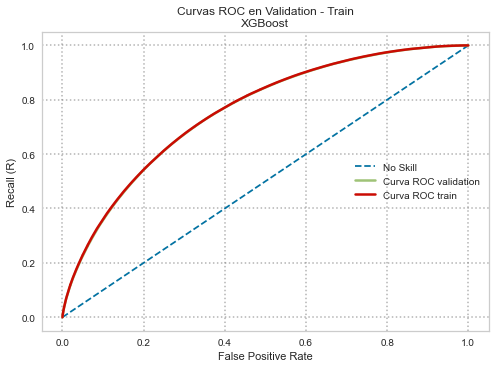

El área bajo la curva ROC de validation es 0.7555367562567538
El área bajo la curva ROC de train es 0.7566964948077614


In [20]:
# Desempeño
fpr, recall, thresholds = metrics.roc_curve(y_valid, bst.predict(dvalid), pos_label=1) 
fpr2, recall2, thresholds = metrics.roc_curve(y_train, bst.predict(dtrain), pos_label=1)
fig,ax = plt.subplots()
plt.plot(fpr,fpr, linestyle='--', label='No Skill')
plt.plot(fpr,recall,lw=2.5,label='Curva ROC validation')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC train')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curvas ROC en Validation - Train\nXGBoost')
plt.show()

area_roc_valid = metrics.roc_auc_score(y_valid, bst.predict(dvalid))
area_roc_train = metrics.roc_auc_score(y_train, bst.predict(dtrain))

print(f"El área bajo la curva ROC de validation es {area_roc_valid}")
print(f"El área bajo la curva ROC de train es {area_roc_train}")

<AxesSubplot:ylabel='feature'>

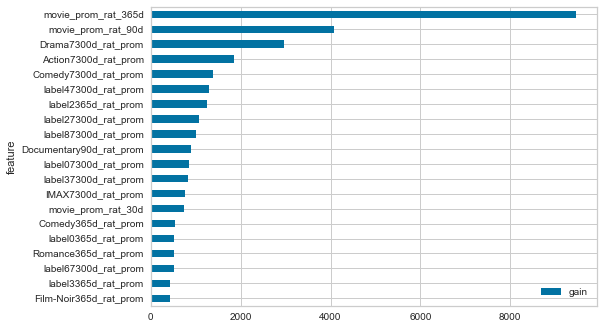

In [19]:
# Feature importance del modelo seleccionado con profundidad máxima de 5 y learning rate de 0.3
f_importance = pd.DataFrame(list(bst.get_score(importance_type='gain').items()), columns = ['feature', 'gain'])
f_importance.sort_values(by='gain', ascending = True).reset_index(drop=True).tail(20).set_index('feature').plot.barh()

In [21]:
del(X_train)
del(y_train)
del(dtrain)

### Performance en el conjunto de prueba

In [53]:
# Lectura de los 4 millones de registros con las 150 variables seleccionadas

chunksize = 1000
test_data = pd.concat([chunk for chunk in pd.read_csv('test_data_2012_2015_final.csv', chunksize=chunksize,
                                                      usecols = ['movieId', 'userId', 'timestamp', 'y']+
                                                                 features_objetivo)],
                      axis = 0)

test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


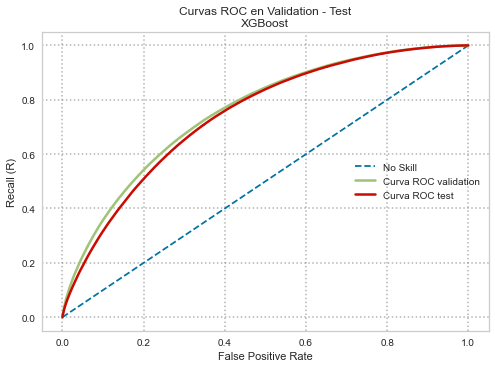

El área bajo la curva ROC de validation es 0.7555367562567538
El área bajo la curva ROC de test es 0.7422840843879459


In [23]:
# Desempeño en test dataset
fpr, recall, thresholds = metrics.roc_curve(y_valid, bst.predict(dvalid), pos_label=1) 
fpr2, recall2, thresholds = metrics.roc_curve(test_data['y'], 
                                              bst.predict(xgb.DMatrix(test_data.drop(['userId', 'movieId', 
                                                                                      'timestamp', 'y'], axis=1))), pos_label=1)
fig,ax = plt.subplots()
plt.plot(fpr,fpr, linestyle='--', label='No Skill')
plt.plot(fpr,recall,lw=2.5,label='Curva ROC validation')
plt.plot(fpr2,recall2,lw=2.5,label='Curva ROC test')
plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curvas ROC en Validation - Test\nXGBoost')
plt.show()

area_roc_valid = metrics.roc_auc_score(y_valid, bst.predict(dvalid))
area_roc_test = metrics.roc_auc_score(test_data['y'], bst.predict(xgb.DMatrix(test_data.drop(['userId', 'timestamp', 'movieId', 'y'], axis=1))))

print(f"El área bajo la curva ROC de validation es {area_roc_valid}")
print(f"El área bajo la curva ROC de test es {area_roc_test}")

In [24]:
# Performance por año

anios = [2012,2013,2014,2015]
for anio in anios:
    area_roc_test = metrics.roc_auc_score(test_data.loc[test_data['timestamp'].dt.year == anio]['y'], 
                                          bst.predict(xgb.DMatrix(test_data.loc[test_data['timestamp'].dt.year == anio].drop(['userId', 'movieId', 'y', 'timestamp'], axis=1))))
    print(f"El área bajo la curva ROC de test en el año {anio} es {area_roc_test}")

El área bajo la curva ROC de test en el año 2012 es 0.7449250424319425
El área bajo la curva ROC de test en el año 2013 es 0.7391523783873111
El área bajo la curva ROC de test en el año 2014 es 0.7398900545310548
El área bajo la curva ROC de test en el año 2015 es 0.7440794222528753


In [26]:
# Performance por mes

anios = [2012,2013,2014,2015]
meses = range(1,13)
aux = []
for anio in anios:
    for mes in meses:
        if (anio < 2015 or mes < 4):
            area_roc_test = metrics.roc_auc_score(test_data.loc[(test_data['timestamp'].dt.year == anio) &
                                                               (test_data['timestamp'].dt.month == mes)]['y'], 
                                                  bst.predict(xgb.DMatrix(test_data.loc[(test_data['timestamp'].dt.year == anio) &
                                                                                       (test_data['timestamp'].dt.month == mes)].drop(['userId', 'movieId', 'y', 'timestamp'], axis=1))))
            print(f"El área bajo la curva ROC de test en el mes {mes} del año {anio} es {area_roc_test}")
            aux.append([str(anio) + '-' + str(mes), np.round(area_roc_test, decimals=3)])

El área bajo la curva ROC de test en el mes 1 del año 2012 es 0.7510911439916392
El área bajo la curva ROC de test en el mes 2 del año 2012 es 0.746532490726782
El área bajo la curva ROC de test en el mes 3 del año 2012 es 0.749332933761851
El área bajo la curva ROC de test en el mes 4 del año 2012 es 0.7244162322337127
El área bajo la curva ROC de test en el mes 5 del año 2012 es 0.7207286472033225
El área bajo la curva ROC de test en el mes 6 del año 2012 es 0.7436261706471546
El área bajo la curva ROC de test en el mes 7 del año 2012 es 0.7404166451334315
El área bajo la curva ROC de test en el mes 8 del año 2012 es 0.7542213739442319
El área bajo la curva ROC de test en el mes 9 del año 2012 es 0.7590451595873251
El área bajo la curva ROC de test en el mes 10 del año 2012 es 0.7418056352910932
El área bajo la curva ROC de test en el mes 11 del año 2012 es 0.7590385145546706
El área bajo la curva ROC de test en el mes 12 del año 2012 es 0.756903944271719
El área bajo la curva ROC de

In [28]:
aux = pd.DataFrame(aux, columns = ['Anio_Mes', 'AUC'])
aux

,Anio_Mes,AUC
0,2012-1,0.751
1,2012-2,0.747
2,2012-3,0.749
3,2012-4,0.724
4,2012-5,0.721
5,2012-6,0.744
6,2012-7,0.740
7,2012-8,0.754
8,2012-9,0.759
9,2012-10,0.742


(0.5, 1.0)

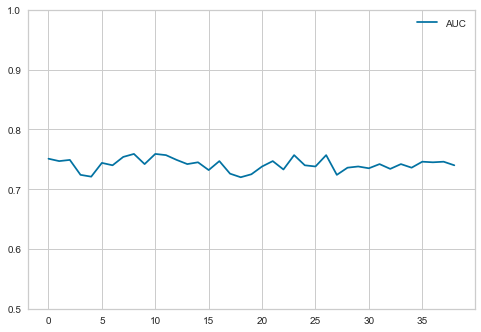

In [37]:
ax = aux.plot()
ax.set_ylim(0.5,1)

In [38]:
del(test_data)

### Punto de corte: Basado en la experiencia del cliente

In [39]:
# Lectura de los 4 millones de registros con las 150 variables seleccionadas

chunksize = 1000
train_data = pd.concat([chunk for chunk in pd.read_csv('train_data_1995_2011_final.csv', chunksize=chunksize,
                                                      usecols = ['movieId', 'userId', 'timestamp', 'y']+
                                                                 features_objetivo)],
                      axis = 0)

In [40]:
train_data.shape

(4000000, 154)

In [42]:
# Unión con el rating
train_data = pd.merge(
    train_data,
    pd.read_csv(os.path.join(mainpath,'rating.csv'), usecols = ['userId', 'movieId', 'rating']),
    on = ['userId', 'movieId'],
    how = 'left'
)

In [9]:
# Carga del modelo
#bst = xgb.Booster()
#bst.load_model('model_150var.json')

In [43]:
prediccionn = bst.predict(xgb.DMatrix(train_data.drop(['userId', 'movieId', 
                                        'timestamp', 'y', 'rating'], axis=1)))

In [44]:
len(prediccionn)

4000000

In [45]:
train_data['prediccion'] = prediccionn

<AxesSubplot:>

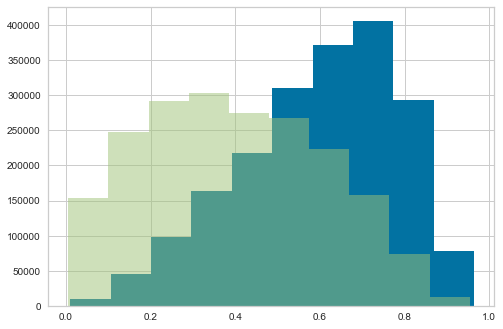

In [46]:
# Distribución de la probabilidad de y = 1
train_data.loc[train_data['y'] == 1].prediccion.hist()
train_data.loc[train_data['y'] == 0].prediccion.hist(alpha = 0.5)

In [47]:
# promedio de NPS_user observado

A = train_data[['prediccion', 'y', 'rating', 'userId']]
A['tipo'] = np.where(A['rating'] >= 4,
                    'prom',
                    np.where(A['rating'] <= 2.5,
                            'det',
                            'pas'))
aux = (A.loc[A.tipo.isin(['prom', 'det'])].groupby(['userId', 'tipo']).rating.count()/A.groupby('userId').tipo.count()).reset_index().pivot(index = 'userId', columns = 'tipo', values = 0).fillna(0).reset_index()
aux['nps'] = aux['prom'] - aux['det']
aux.nps.mean()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.39949662771093486

In [48]:
train_data['userId'].nunique()

123909

In [49]:
# Optimización del promedio de (NPS por usuario)

comp = -999999999
train_data_aux = train_data[['prediccion', 'y', 'rating', 'userId']]

for corte in np.arange(0.001,0.999,0.001):
    A = train_data_aux.loc[train_data['prediccion'] >= corte]
    if A['userId'].nunique() >= 111600:
        A['tipo'] = np.where(A['rating'] >= 4,
                            'prom',
                            np.where(A['rating'] <= 2.5,
                                    'det',
                                    'pas'))
        aux = (A.loc[A.tipo.isin(['prom', 'det'])].groupby(['userId', 'tipo']).rating.count()/A.groupby('userId').tipo.count()).reset_index().pivot(index = 'userId', columns = 'tipo', values = 0).fillna(0).reset_index()
        aux['nps'] = aux['prom'] - aux['det']
        met = aux.nps.mean()

        if met > comp:
            punto_corte = corte
            met_optima = met
    print('Iteración: ', corte)
    print('Punto de corte: ', punto_corte)
    print('Métrica óptima: ', met_optima)

Iteración:  0.001
Punto de corte:  0.001
Métrica óptima:  0.39949662771093486
Iteración:  0.002
Punto de corte:  0.002
Métrica óptima:  0.39949662771093486
Iteración:  0.003
Punto de corte:  0.003
Métrica óptima:  0.39949662771093486
Iteración:  0.004
Punto de corte:  0.004
Métrica óptima:  0.39949662771093486
Iteración:  0.005
Punto de corte:  0.005
Métrica óptima:  0.39949662771093486



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Iteración:  0.006
Punto de corte:  0.006
Métrica óptima:  0.3994966342230826
Iteración:  0.007
Punto de corte:  0.007
Métrica óptima:  0.3994967398155755
Iteración:  0.008
Punto de corte:  0.008
Métrica óptima:  0.39949709877219797
Iteración:  0.009000000000000001
Punto de corte:  0.009000000000000001
Métrica óptima:  0.3994978949573022
Iteración:  0.010000000000000002
Punto de corte:  0.010000000000000002
Métrica óptima:  0.39949923601587883
Iteración:  0.011
Punto de corte:  0.011
Métrica óptima:  0.3995021741038512
Iteración:  0.012
Punto de corte:  0.012
Métrica óptima:  0.3995076441614254
Iteración:  0.013000000000000001
Punto de corte:  0.013000000000000001
Métrica óptima:  0.39951526367199847
Iteración:  0.014000000000000002
Punto de corte:  0.014000000000000002
Métrica óptima:  0.3995256625820726
Iteración:  0.015
Punto de corte:  0.015
Métrica óptima:  0.3995379197580659
Iteración:  0.016
Punto de corte:  0.016
Métrica óptima:  0.39955226460064436
Iteración:  0.017
Punto de co

Iteración:  0.10300000000000001
Punto de corte:  0.10300000000000001
Métrica óptima:  0.410278406948478
Iteración:  0.10400000000000001
Punto de corte:  0.10400000000000001
Métrica óptima:  0.41042349883632645
Iteración:  0.10500000000000001
Punto de corte:  0.10500000000000001
Métrica óptima:  0.4105847949496629
Iteración:  0.106
Punto de corte:  0.106
Métrica óptima:  0.4108920181423291
Iteración:  0.107
Punto de corte:  0.107
Métrica óptima:  0.41127162298450776
Iteración:  0.108
Punto de corte:  0.108
Métrica óptima:  0.4116028084825205
Iteración:  0.109
Punto de corte:  0.109
Métrica óptima:  0.41192390027317405
Iteración:  0.11
Punto de corte:  0.11
Métrica óptima:  0.4122142075622468
Iteración:  0.111
Punto de corte:  0.111
Métrica óptima:  0.4124085347986437
Iteración:  0.112
Punto de corte:  0.112
Métrica óptima:  0.4126580219502856
Iteración:  0.113
Punto de corte:  0.113
Métrica óptima:  0.4129173059530646
Iteración:  0.114
Punto de corte:  0.114
Métrica óptima:  0.413144053

Iteración:  0.20400000000000001
Punto de corte:  0.20400000000000001
Métrica óptima:  0.44414408969938307
Iteración:  0.20500000000000002
Punto de corte:  0.20500000000000002
Métrica óptima:  0.44447127017265214
Iteración:  0.20600000000000002
Punto de corte:  0.20600000000000002
Métrica óptima:  0.4449026949632025
Iteración:  0.20700000000000002
Punto de corte:  0.20700000000000002
Métrica óptima:  0.4454618476964587
Iteración:  0.20800000000000002
Punto de corte:  0.20800000000000002
Métrica óptima:  0.4459032646082443
Iteración:  0.20900000000000002
Punto de corte:  0.20900000000000002
Métrica óptima:  0.4464332582044114
Iteración:  0.21
Punto de corte:  0.21
Métrica óptima:  0.44689610067919244
Iteración:  0.211
Punto de corte:  0.211
Métrica óptima:  0.44748356705849507
Iteración:  0.212
Punto de corte:  0.212
Métrica óptima:  0.4481053956577221
Iteración:  0.213
Punto de corte:  0.213
Métrica óptima:  0.44859447665020175
Iteración:  0.214
Punto de corte:  0.214
Métrica óptima:  0

Iteración:  0.303
Punto de corte:  0.303
Métrica óptima:  0.49154288758189196
Iteración:  0.304
Punto de corte:  0.304
Métrica óptima:  0.49198979950535593
Iteración:  0.305
Punto de corte:  0.305
Métrica óptima:  0.49233582044557117
Iteración:  0.306
Punto de corte:  0.306
Métrica óptima:  0.4928090946467615
Iteración:  0.307
Punto de corte:  0.307
Métrica óptima:  0.4932061780425095
Iteración:  0.308
Punto de corte:  0.308
Métrica óptima:  0.4936527904940856
Iteración:  0.309
Punto de corte:  0.309
Métrica óptima:  0.49429973169621566
Iteración:  0.31
Punto de corte:  0.31
Métrica óptima:  0.49494381148988176
Iteración:  0.311
Punto de corte:  0.311
Métrica óptima:  0.4955568804750701
Iteración:  0.312
Punto de corte:  0.312
Métrica óptima:  0.49622592853306075
Iteración:  0.313
Punto de corte:  0.313
Métrica óptima:  0.49685737227738763
Iteración:  0.314
Punto de corte:  0.314
Métrica óptima:  0.4975055318975789
Iteración:  0.315
Punto de corte:  0.315
Métrica óptima:  0.49810030833

Iteración:  0.40700000000000003
Punto de corte:  0.40700000000000003
Métrica óptima:  0.5497579505059241
Iteración:  0.40800000000000003
Punto de corte:  0.40800000000000003
Métrica óptima:  0.550249837526493
Iteración:  0.40900000000000003
Punto de corte:  0.40900000000000003
Métrica óptima:  0.5509062939286373
Iteración:  0.41000000000000003
Punto de corte:  0.41000000000000003
Métrica óptima:  0.551396202190396
Iteración:  0.41100000000000003
Punto de corte:  0.41100000000000003
Métrica óptima:  0.5519572476845427
Iteración:  0.41200000000000003
Punto de corte:  0.41200000000000003
Métrica óptima:  0.552528430201201
Iteración:  0.41300000000000003
Punto de corte:  0.41300000000000003
Métrica óptima:  0.5530148794278776
Iteración:  0.41400000000000003
Punto de corte:  0.41400000000000003
Métrica óptima:  0.5535682374497902
Iteración:  0.41500000000000004
Punto de corte:  0.41500000000000004
Métrica óptima:  0.5540869108899494
Iteración:  0.41600000000000004
Punto de corte:  0.4160000

Iteración:  0.506
Punto de corte:  0.506
Métrica óptima:  0.604568320385859
Iteración:  0.507
Punto de corte:  0.507
Métrica óptima:  0.6052642943936251
Iteración:  0.508
Punto de corte:  0.508
Métrica óptima:  0.6059725825266146
Iteración:  0.509
Punto de corte:  0.509
Métrica óptima:  0.6065703524927102
Iteración:  0.51
Punto de corte:  0.51
Métrica óptima:  0.6072389918864332
Iteración:  0.511
Punto de corte:  0.511
Métrica óptima:  0.6078146132966796
Iteración:  0.512
Punto de corte:  0.512
Métrica óptima:  0.6082389643454023
Iteración:  0.513
Punto de corte:  0.513
Métrica óptima:  0.6087947451171178
Iteración:  0.514
Punto de corte:  0.514
Métrica óptima:  0.6094325775266928
Iteración:  0.515
Punto de corte:  0.515
Métrica óptima:  0.610007730083868
Iteración:  0.516
Punto de corte:  0.516
Métrica óptima:  0.610730723255068
Iteración:  0.517
Punto de corte:  0.517
Métrica óptima:  0.6110997939612567
Iteración:  0.518
Punto de corte:  0.518
Métrica óptima:  0.6119292526230198
Iter

Iteración:  0.608
Punto de corte:  0.608
Métrica óptima:  0.6728017772149245
Iteración:  0.609
Punto de corte:  0.609
Métrica óptima:  0.6734137332082003
Iteración:  0.61
Punto de corte:  0.61
Métrica óptima:  0.6740268514133146
Iteración:  0.611
Punto de corte:  0.611
Métrica óptima:  0.6747013582160588
Iteración:  0.612
Punto de corte:  0.612
Métrica óptima:  0.6753086797850779
Iteración:  0.613
Punto de corte:  0.613
Métrica óptima:  0.6760543331054754
Iteración:  0.614
Punto de corte:  0.614
Métrica óptima:  0.6766525963942548
Iteración:  0.615
Punto de corte:  0.615
Métrica óptima:  0.6773132999261826
Iteración:  0.616
Punto de corte:  0.616
Métrica óptima:  0.6779839120194424
Iteración:  0.617
Punto de corte:  0.617
Métrica óptima:  0.6789868800731347
Iteración:  0.618
Punto de corte:  0.618
Métrica óptima:  0.6795521885603227
Iteración:  0.619
Punto de corte:  0.619
Métrica óptima:  0.6801856566297916
Iteración:  0.62
Punto de corte:  0.62
Métrica óptima:  0.6808762042243801
Ite

Iteración:  0.715
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.716
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.717
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.718
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.719
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.72
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.721
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.722
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.723
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.724
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.725
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.726
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.727
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278


Iteración:  0.8240000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.8250000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.8260000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.8270000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.8280000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.8290000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.8300000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.8310000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.8320000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.8330000000000001
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.834
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.835
Punto

Iteración:  0.988
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.989
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.99
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.991
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.992
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.993
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.994
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.995
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.996
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.997
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278
Iteración:  0.998
Punto de corte:  0.677
Métrica óptima:  0.7211959999811278


In [50]:
print(punto_corte)
print(met_optima)

0.677
0.7211959999811278


In [52]:
del(train_data)

##### Promedio NPS user con el punto de corte óptimo para los datos de test 

In [54]:
# Unión con el rating
test_data = pd.merge(
    test_data,
    pd.read_csv(os.path.join(mainpath,'rating.csv'), usecols = ['userId', 'movieId', 'rating']),
    on = ['userId', 'movieId'],
    how = 'left'
)

In [55]:
prediccionn = bst.predict(xgb.DMatrix(test_data.drop(['userId', 'movieId', 
                                        'timestamp', 'y', 'rating'], axis=1)))

In [56]:
len(prediccionn)

2177490

In [57]:
test_data['prediccion'] = prediccionn

In [60]:
# Predicción para los datos de test
A = test_data[['prediccion', 'y', 'rating', 'userId']]
A = A.loc[A['prediccion'] >= 0.677]
A['tipo'] = np.where(A['rating'] >= 4,
                    'prom',
                    np.where(A['rating'] <= 2.5,
                            'det',
                            'pas'))
aux = (A.loc[A.tipo.isin(['prom', 'det'])].groupby(['userId', 'tipo']).rating.count()/A.groupby('userId').tipo.count()).reset_index().pivot(index = 'userId', columns = 'tipo', values = 0).fillna(0).reset_index()
aux['nps'] = aux['prom'] - aux['det']
aux.nps.mean()

0.6839681270777969

In [61]:
# Promedio de NPS_user observado para los datos de test
A = test_data[['prediccion', 'y', 'rating', 'userId']]
A['tipo'] = np.where(A['rating'] >= 4,
                    'prom',
                    np.where(A['rating'] <= 2.5,
                            'det',
                            'pas'))
aux = (A.loc[A.tipo.isin(['prom', 'det'])].groupby(['userId', 'tipo']).rating.count()/A.groupby('userId').tipo.count()).reset_index().pivot(index = 'userId', columns = 'tipo', values = 0).fillna(0).reset_index()
aux['nps'] = aux['prom'] - aux['det']
aux.nps.mean()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.43859845915906365

In [70]:
# Promedio de NPS_user por año y mes

anios = [2012,2013,2014,2015]
meses = range(1,13)
aux_nps = []
for anio in anios:
    for mes in meses:
        if (anio < 2015 or mes < 4):
            A = test_data[['prediccion', 'y', 'rating', 'userId', 'timestamp']]
            A = A.loc[A['prediccion'] >= 0.677]
            A = A.loc[(A['timestamp'].dt.year == anio) & (A['timestamp'].dt.month == mes)]
            A['tipo'] = np.where(A['rating'] >= 4,
                                'prom',
                                np.where(A['rating'] <= 2.5,
                                        'det',
                                        'pas'))
            aux = (A.loc[A.tipo.isin(['prom', 'det'])].groupby(['userId', 'tipo']).rating.count()/A.groupby('userId').tipo.count()).reset_index().pivot(index = 'userId', columns = 'tipo', values = 0).fillna(0).reset_index()
            aux['nps'] = aux['prom'] - aux['det']
            
            #El observado
            B = test_data[['prediccion', 'y', 'rating', 'userId', 'timestamp']]
            B = B.loc[(B['timestamp'].dt.year == anio) & (B['timestamp'].dt.month == mes)]
            B['tipo'] = np.where(B['rating'] >= 4,
                                'prom',
                                np.where(B['rating'] <= 2.5,
                                        'det',
                                        'pas'))
            Bux = (B.loc[B.tipo.isin(['prom', 'det'])].groupby(['userId', 'tipo']).rating.count()/B.groupby('userId').tipo.count()).reset_index().pivot(index = 'userId', columns = 'tipo', values = 0).fillna(0).reset_index()
            Bux['nps'] = Bux['prom'] - Bux['det']
            Bux.nps.mean()
            aux_nps.append([str(anio) + '-' + str(mes), aux.nps.mean(), Bux.nps.mean()])            
            print(mes)
    print(anio)

1
2
3
4
5
6
7
8
9
10
11
12
2012
1
2
3
4
5
6
7
8
9
10
11
12
2013
1
2
3
4
5
6
7
8
9
10
11
12
2014
1
2
3
2015


In [71]:
aux_nps = pd.DataFrame(aux_nps, columns = ['Anio_Mes', 'NPS_user_pred', 'NPS_user_obsserv'])
aux_nps

,Anio_Mes,NPS_user_pred,NPS_user_obsserv
0,2012-1,0.773971,0.370097
1,2012-2,0.752513,0.394716
2,2012-3,0.764628,0.405256
3,2012-4,0.762623,0.404814
4,2012-5,0.756814,0.399587
5,2012-6,0.759394,0.381302
6,2012-7,0.753875,0.393439
7,2012-8,0.760066,0.393346
8,2012-9,0.755768,0.383132
9,2012-10,0.754519,0.401777


(0.0, 1.0)

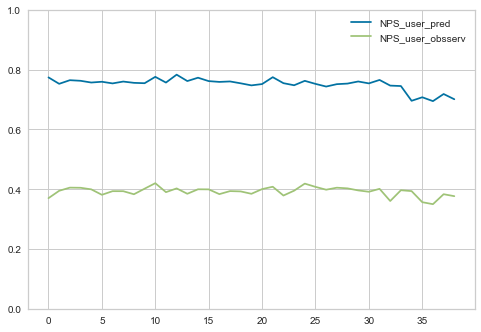

In [73]:
ax = aux_nps.plot()
ax.set_ylim(0,1)